# <center> Предсказание победителя в Dota 2
<center> <img src="https://meduza.io/impro/YnJZAHUW6WHz_JQm1uRPkTql_qAhbfxt3oFJLGH7CJg/fill/980/0/ce/1/aHR0cHM6Ly9tZWR1/emEuaW8vaW1hZ2Uv/YXR0YWNobWVudHMv/aW1hZ2VzLzAwNy8x/NTcvNjk1L29yaWdp/bmFsL0tMVThLbUti/ZG5pSzlibDA0Wmlw/WXcuanBn.webp" width="700" height="700">

[Почитать подбробнее](https://meduza.io/feature/2021/10/19/rossiyskaya-komanda-vyigrala-chempionat-mira-po-dota-2-i-poluchila-18-millionov-dollarov-postoyte-otkuda-takie-dengi-neuzheli-igrat-v-dotu-tak-slozhno)

#### [Оригинальная статья](https://arxiv.org/pdf/2106.01782.pdf)
    
### Начало

Посмотрим на готовые признаки и сделаем первую посылку.

1. [Описание данных](#Описание-данных)
2. [Описание признаков](#Описание-признаков)
3. [Наша первая модель](#Наша-первая-модель)
4. [Посылка](#Посылка)

### Первые шаги на пути в датасайенс

5. [Кросс-валидация](#Кросс-валидация)
6. [Что есть в json файлах?](#Что-есть-в-json-файлах?)
7. [Feature engineering](#Feature-engineering)

### Импорты

In [1]:
import os
import json
import numpy as np
import pandas as pd
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score


import xgboost
from catboost import CatBoostClassifier, Pool, metrics, cv
from hyperopt import fmin, hp, STATUS_OK, Trials, tpe

%matplotlib inline

In [2]:
SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

## <left>Описание данных

Файлы:

- `sample_submission.csv`: пример файла-посылки
- `train_raw_data.jsonl`, `test_raw_data.jsonl`: "сырые" данные
- `train_data.csv`, `test_data.csv`: признаки, созданные авторами
- `train_targets.csv`: результаты тренировочных игр

## <left>Описание признаков
    
Набор простых признаков, описывающих игроков и команды в целом

In [3]:
PATH_TO_DATA = "../data/"

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA,
                                             "train_data.csv"),
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA,
                                            "train_targets.csv"),
                                   index_col="match_id_hash")

In [4]:
df_train_features.shape

(31698, 245)

In [5]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


Имеем ~32 тысячи наблюдений, каждое из которых характеризуется уникальным `match_id_hash` (захэшированное id матча), и 245 признаков. `game_time` показывает момент времени, в который получены эти данные. То есть по сути это не длительность самого матча, а например, его середина, таким образом, в итоге мы сможем получить модель, которая будет предсказывать вероятность победы каждой из команд в течение матча (хорошо подходит для букмекеров).

Нас интересует поле `radiant_win` (так называется одна из команд, вторая - dire). Остальные колоки здесь по сути получены из "будущего" и есть только для тренировочных данных, поэтому на них можно просто посмотреть).

In [6]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire


## <left>Наша первая модель

In [7]:
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      test_size=0.3,
                                                      random_state=SEED)

#### Обучим случайный лес

In [9]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)

CPU times: total: 19.1 s
Wall time: 3.12 s


RandomForestClassifier(max_depth=7, n_estimators=300, n_jobs=-1,
                       random_state=10801)

#### Сделаем предсказания и оценим качество на отложенной части данных

In [10]:
y_pred = rf_model.predict_proba(X_valid)[:, 1]

In [11]:
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.7754387258058622


Посмотрим на accuracy:

In [12]:
valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

Accuracy score (p > 0.5) на отложенной части: 0.6885383806519453


## <left>Посылка

In [13]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"),
                                   index_col="match_id_hash")

X_test = df_test_features.values
y_test_pred = rf_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred},
                                 index=df_test_features.index)

Здесь и далее буду комменировать запись файла и не прогонять ячейку, иначе не будут совпадать с уже посланными

In [15]:
#submission_filename = "submission_{}.csv".format(
#    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
#df_submission.to_csv(submission_filename)
#print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2024-03-17_14-53-00.csv


## <left>Кросс-валидация

Во многих случаях кросс-валидация оказывается лучше простого разбиения на test и train. Воспользуемся `ShuffleSplit` чтобы создать 5 70%/30% наборов данных.

In [16]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [17]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")

CPU times: total: 3.06 s
Wall time: 25.7 s


In [18]:
cv_scores_rf

array([0.77543873, 0.77343884, 0.76649967, 0.7722681 , 0.77246001])

In [19]:
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7720210676055513


## <left>Что есть в json файлах?

Описание сырых данных можно найти в `train_matches.jsonl` и `test_matches.jsonl`. Каждый файл содержит одну запись для каждого матча в [JSON](https://en.wikipedia.org/wiki/JSON) формате. Его легко превратить в питоновский объект при помощи метода `json.loads`.

In [20]:
with open(os.path.join(PATH_TO_DATA, "train_raw_data.jsonl")) as fin:
    # прочтем 419 строку
    for i in range(419):
        line = fin.readline()

    # переведем JSON в питоновский словарь
    match = json.loads(line)

In [21]:
player = match["players"][9]
player["kills"], player["deaths"], player["assists"]

(0, 5, 5)

KDA - может быть неплохим признаком, этот показатель считается как:
    
<center>$KDA = \frac{K + A}{D}$

Информация о количестве использованных способностей:

In [23]:
player["ability_uses"]

{'treant_living_armor': 52, 'treant_leech_seed': 5, 'treant_overgrowth': 5}

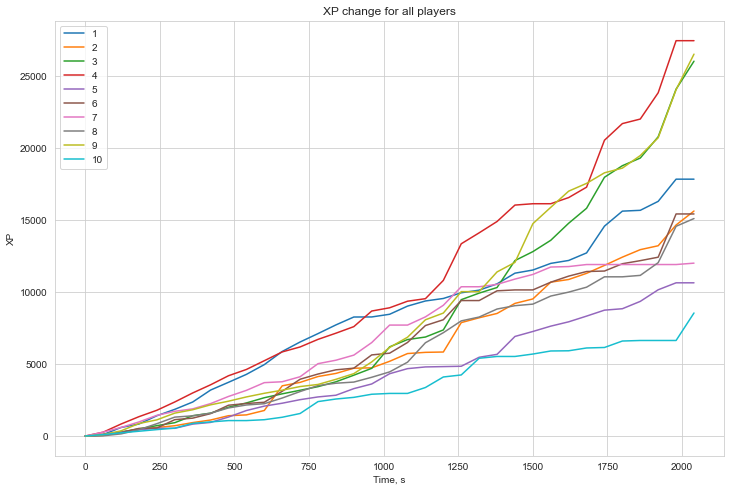

In [24]:
for i, player in enumerate(match["players"]):
    plt.plot(player["times"], player["xp_t"], label=str(i+1))

plt.legend()
plt.xlabel("Time, s")
plt.ylabel("XP")
plt.title("XP change for all players");

#### Сделаем чтение файла с сырыми данными и добавление новых признаков удобным

В этот раз для чтение `json` файлов лучше использовать библиотеку `ujson`, иначе все будет слишком долго :(

In [25]:
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ("Подумайте об установке ujson, чтобы работать с JSON объектами быстрее")

try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ("Подумайте об установке tqdm, чтобы следить за прогрессом")


def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):
    """
    Аргуент
    -------
    matches_file: JSON файл с сырыми данными

    Результат
    ---------
    Возвращает записи о каждом матче
    """

    if n_matches_to_read is None:
        n_matches_to_read = total_matches

    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

#### Чтение данных в цикле

Чтение всех данных занимает 1-2 минуты, поэтому для начала можно попробовать следующее:

1. Читать 10-50 игр
2. Написать код для работы с этими JSON объектами
3. Убедиться, что все работает
4. Запустить код на всем датасете
5. Сохранить результат в `pickle` файл, чтобы в следующий раз не переделывать все заново

## <left>Feature engineering

Напишем функцию, которая поможет нам легче добавлять новые признаки.

In [26]:
def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными

    Результат
    ---------
    Добавляет новые признаки в таблицу
    """

    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills

        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...

In [27]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended,
                 os.path.join(PATH_TO_DATA,
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [28]:
df_train_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_tower_kills,dire_tower_kills,diff_tower_kills
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0,0,0.00,0,0,0,0,2.0,0.0,2.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,3,0,0.25,0,0,3,0,0.0,0.0,0.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,0,1,0.50,0,0,3,0,0.0,1.0,-1.0


In [29]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y,
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: total: 125 ms
Wall time: 49.9 s


In [30]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7720210676055513
ROC-AUC на кросс-валидации для новых признаков: 0.778796825263235


Видно, что случайный лес стал работать немного лучше при добавлении новых признаков. A еще нужно, наверное, как-то по-умному закодировать категориальные признаки.

Дальше дело за малым. Добавляйте новые признаки, пробуйте другие методы, которые мы изучили, а также что-то интересное, что мы не прошли. Удачи!

Для начала посмотрим что у нас есть

In [31]:
match.keys()

dict_keys(['game_time', 'match_id_hash', 'teamfights', 'objectives', 'chat', 'game_mode', 'lobby_type', 'players', 'targets'])

In [32]:
match["players"][0].keys()

dict_keys(['player_slot', 'hero_id', 'hero_name', 'account_id_hash', 'ability_upgrades', 'obs_placed', 'sen_placed', 'creeps_stacked', 'camps_stacked', 'rune_pickups', 'firstblood_claimed', 'teamfight_participation', 'towers_killed', 'roshans_killed', 'observers_placed', 'stuns', 'max_hero_hit', 'times', 'gold_t', 'lh_t', 'dn_t', 'xp_t', 'obs_log', 'sen_log', 'obs_left_log', 'sen_left_log', 'purchase_log', 'kills_log', 'buyback_log', 'runes_log', 'obs', 'sen', 'actions', 'pings', 'purchase', 'gold_reasons', 'xp_reasons', 'killed', 'item_uses', 'ability_uses', 'hero_hits', 'damage', 'damage_taken', 'damage_inflictor', 'runes', 'killed_by', 'kill_streaks', 'multi_kills', 'life_state', 'healing', 'damage_inflictor_received', 'randomed', 'pred_vict', 'gold', 'lh', 'xp', 'x', 'y', 'hero_inventory', 'hero_stash', 'health', 'max_health', 'max_mana', 'level', 'kills', 'deaths', 'assists', 'denies', 'nearby_creep_death_count'])

Я предполгаю что level игроков будет влиять, так что добавим. Также добавим КДА

In [33]:
def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными

    Результат
    ---------
    Добавляет новые признаки в таблицу
    """

    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        # средний уровень игроков
        all_levels = []
        for player in match["players"]:
            all_levels.append(player['level'])
        df_features.loc[match_id_hash, "r_mean_level"] = sum(all_levels[:5]) / 5
        df_features.loc[match_id_hash, "d_mean_level"] = sum(all_levels[5:]) / 5

        #суммируются все киллы и ассисты, и делятся на количество смертей
        kda_common = []
        for player in match["players"]:
            kda_common.append((player['kills'] + player['assists']) / (player['deaths'] + 0.01)) 
        df_features.loc[match_id_hash, "r_KDA"] = sum(kda_common[:5])
        df_features.loc[match_id_hash, "d_KDA"] = sum(kda_common[5:])

In [34]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended,
                 os.path.join(PATH_TO_DATA,
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [35]:
df_train_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_tower_kills,dire_tower_kills,diff_tower_kills,r_mean_level,d_mean_level,r_KDA,d_KDA
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0,0,0,2.0,0.0,2.0,7.4,6.0,1313.383577,1.992805
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0,0,0,0.0,0.0,0.0,1.0,1.0,0.000000,0.000000
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0,0,0,0.0,0.0,0.0,2.4,2.2,0.000000,0.000000
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,0,3,0,0.0,0.0,0.0,9.6,9.8,10.524128,409.443746
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,0,3,0,0.0,1.0,-1.0,5.8,5.8,10.400158,511.403379


In [36]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y,
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: total: 125 ms
Wall time: 51.5 s


In [37]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7720210676055513
ROC-AUC на кросс-валидации для новых признаков: 0.7866807502261207


Улучшение есть, но не прям чтоьбы мощное. Подумаем что еще можно добавить.

Попробуем количество разрушщенных башен и количество золота в среднем.

In [38]:
def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными

    Результат
    ---------
    Добавляет новые признаки в таблицу
    """

    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        # средний уровень игроков
        all_levels = []
        for player in match["players"]:
            all_levels.append(player['level'])
        df_features.loc[match_id_hash, "r_mean_level"] = sum(all_levels[:5]) / 5
        df_features.loc[match_id_hash, "d_mean_level"] = sum(all_levels[5:]) / 5

        #суммируются все лиллы и ассисты, и делятся на количество смертей
        kda_common = []
        for player in match["players"]:
            kda_common.append((player['kills'] + player['assists']) / (player['deaths'] + 0.01)) 
        df_features.loc[match_id_hash, "r_KDA"] = sum(kda_common[:5])
        df_features.loc[match_id_hash, "d_KDA"] = sum(kda_common[5:])
        
        # среднее золото
        golds = []
        for player in match["players"]:
            golds.append(player['gold'])
        df_features.loc[match_id_hash, "r_gold"] = sum(golds[:5])
        df_features.loc[match_id_hash, "d_gold"] = sum(golds[5:])
        
        # Число башен
        towers = []
        for player in match["players"]:
            golds.append(player['towers_killed'])
        df_features.loc[match_id_hash, "r_towers_killed"] = sum(towers[:5])
        df_features.loc[match_id_hash, "d_towers_killed"] = sum(towers[5:])
        
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended,
                 os.path.join(PATH_TO_DATA,
                              "train_raw_data.jsonl"))


  0%|          | 0/31698 [00:00<?, ?it/s]

In [39]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y,
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: total: 78.1 ms
Wall time: 48.1 s


In [40]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7720210676055513
ROC-AUC на кросс-валидации для новых признаков: 0.787402273347946


Скор стал выше. Попробуем что будет, если использовать другую модель.

# Сделаем xgboost.XGBClassifier.
В этот раз я нашла новый способ подбора гиперпараметров, так что будем пользоваться им [hyperopt.fmin()](https://github.com/hyperopt/hyperopt/wiki/FMin?ysclid=ltvaiorxsk981664823). [Here too](https://habr.com/ru/articles/542624/)

In [41]:
params = {"learning_rate": hp.uniform('learning_rate', 0.01, 0.3),
          'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
          'gamma': hp.uniform('gamma', 0.1, 1.5),
          'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1),
          'max_depth': hp.quniform('max_depth', 1, 10, 1),
          'n_estimators': hp.uniform('n_estimators', 100, 1000),
          'subsample': hp.uniform ('subsample', 0.2, 1),
          'seed': SEED,
    }

In [42]:
def objective(params):
    clf=xgboost.XGBClassifier(learning_rate=params['learning_rate'],
                              min_child_weight=int(params['min_child_weight']),
                              gamma=params['gamma'],
                              colsample_bytree=params['colsample_bytree'],
                              max_depth=int(params['max_depth']),
                              n_estimators=int(params['n_estimators']), 
                              subsample=params['subsample'],
                             )
    
    evaluation = [( X_train, y_train), ( X_valid, y_valid)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, early_stopping_rounds=10,
            eval_metric="auc", verbose=False)
    

    pred = clf.predict(X_valid)
    accuracy = accuracy_score(y_valid, pred>0.5)
    #print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

Следующее окошко работает довольно долго, так что предлагаю их не прогонять, в получившуюся модель я уже подставила лучшие гиперпараметры.

In [10]:
from hyperopt import fmin, hp, STATUS_OK, Trials, tpe

trials = Trials()

best_hyperparams = fmin(fn=objective,
                        space=params,
                        algo=tpe.suggest,
                        max_evals=100,
                        trials=trials)

100%|█████████████████████████████████████████████| 100/100 [15:59<00:00,  9.60s/trial, best loss: -0.7139852786540484]


In [11]:
best_hyperparams

{'colsample_bytree': 0.5505092876383103,
 'gamma': 0.4491346332887211,
 'learning_rate': 0.023040097673543286,
 'max_depth': 9.0,
 'min_child_weight': 6.0,
 'n_estimators': 434.04928399613044,
 'subsample': 0.6483603056308186}

Лучшие гиперпараметры:
```
'colsample_bytree': 0.5505092876383103,
 'gamma': 0.4491346332887211,
 'learning_rate': 0.023040097673543286,
 'max_depth': 9.0,
 'min_child_weight': 6.0,
 'n_estimators': 434.04928399613044,
 'subsample': 0.6483603056308186
```


In [44]:
xgb_class = xgboost.XGBClassifier(colsample_bytree=0.5505092876383103, 
                                  gamma=0.4491346332887211, 
                                  learning_rate=0.023040097673543286, 
                                  max_depth=9, 
                                  min_child_weight=6, 
                                  n_estimators=int(434.04928399613044), 
                                  subsample=0.6483603056308186)
xgb_class.fit(X_train, y_train)
y_pred = xgb_class.predict_proba(X_valid)[:, 1]

In [45]:
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.8009849998385667


Отправку закомментирую

In [46]:
# senging
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                   index_col="match_id_hash")

X_test = df_test_features.values
y_test_pred = xgb_class.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

In [15]:
#submission_filename = "submission_{}.csv".format(
#    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
#df_submission.to_csv(submission_filename)
#print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2024-03-17_15-48-36.csv


In [47]:
# cross-valid
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [48]:
%%time
cv_scores_xgb = cross_val_score(xgb_class, X, y, cv=cv, scoring="roc_auc")

CPU times: total: 7min 2s
Wall time: 1min 7s


In [49]:
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_xgb.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7985549266699611


Хорошее начало, теперь добавим те же признаки, что были добавлены ранее на рандомном лесе

In [50]:
def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными

    Результат
    ---------
    Добавляет новые признаки в таблицу
    """

    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        # средний уровень игроков
        all_levels = []
        for player in match["players"]:
            all_levels.append(player['level'])
        df_features.loc[match_id_hash, "r_mean_level"] = sum(all_levels[:5]) / 5
        df_features.loc[match_id_hash, "d_mean_level"] = sum(all_levels[5:]) / 5

        #суммируются все Киллы и Ассисты, и делятся на количество Смертей. Вывод: чем выше КДА, тем лучше
        kda_common = []
        for player in match["players"]:
            kda_common.append((player['kills'] + player['assists']) / (player['deaths'] + 0.01)) 
        df_features.loc[match_id_hash, "r_KDA"] = sum(kda_common[:5])
        df_features.loc[match_id_hash, "d_KDA"] = sum(kda_common[5:])
        
        # среднее золото
        golds = []
        for player in match["players"]:
            golds.append(player['gold'])
        df_features.loc[match_id_hash, "r_gold"] = sum(golds[:5])
        df_features.loc[match_id_hash, "d_gold"] = sum(golds[5:])
        
        # Число башен
        towers = []
        for player in match["players"]:
            golds.append(player['towers_killed'])
        df_features.loc[match_id_hash, "r_towers_killed"] = sum(towers[:5])
        df_features.loc[match_id_hash, "d_towers_killed"] = sum(towers[5:])
        
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended,
                 os.path.join(PATH_TO_DATA,
                              "train_raw_data.jsonl"))


  0%|          | 0/31698 [00:00<?, ?it/s]

In [51]:
%%time
cv_scores_base = cross_val_score(xgb_class, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(xgb_class, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: total: 125 ms
Wall time: 1min 43s


In [52]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7985549266699611
ROC-AUC на кросс-валидации для новых признаков: 0.8017919568581071


Пока самый высокий скор у меня. Отправим, как обычно заккоменчу

Готовимся к отправлению:

In [53]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), index_col="match_id_hash")
df_test_features_extended = df_test_features.copy()

add_new_features(df_test_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "test_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [54]:
X = df_train_features_extended.values
y = df_train_targets['radiant_win'].values

xgb_class.fit(X, y)
X_test = df_test_features_extended.values
y_test_pred = xgb_class.predict_proba(X_test)[:, 1]

In [55]:
df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                             index=df_test_features_extended.index)

In [30]:
#submission_filename = "submission_{}.csv".format(
#    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
#df_submission.to_csv(submission_filename)
#print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2024-03-17_15-56-37.csv


# Попробуем с теми же изменениями catboost. 
[Tuning (4)](https://notebooks.githubusercontent.com/view/ipynb?browser=chrome&bypass_fastly=true&color_mode=auto&commit=99400b8d869514bda886ff09a6580a53b5f08674&device=unknown_device&docs_host=https%3A%2F%2Fdocs.github.com&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f636174626f6f73742f7475746f7269616c732f393934303062386438363935313462646138383666663039613635383061353362356630383637342f707974686f6e5f7475746f7269616c2e6970796e62&logged_in=false&nwo=catboost%2Ftutorials&path=python_tutorial.ipynb&platform=unknown_platform&repository_id=138584767&repository_type=Repository&version=108)


In [56]:
import catboost

In [57]:
clf = catboost.CatBoostClassifier(verbose = False)
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_valid)[:, 1]
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.8000716603814152


In [58]:
model = CatBoostClassifier(iterations=50, random_seed=SEED, logging_level='Silent').fit(X_train, y_train)
eval_metrics = model.eval_metrics(Pool(X_valid, y_valid), [metrics.AUC()], plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [59]:
clf = catboost.CatBoostClassifier(l2_leaf_reg = 2,
                                  learning_rate=0.05,
                                  random_seed=SEED,
                                  eval_metric=metrics.AUC(),
                                  verbose = False)
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_valid)[:, 1]
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.79929429736282


Подбираем параметры

In [66]:
params = {
    'l2_leaf_reg': hp.quniform('l2_leaf_reg', 0, 2, 1),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.5),
    'loss_function': hp.choice('loss_function', ['Logloss', 'CrossEntropy', 'MultiClass', 'MultiClassOneVsAll']),
    'iterations': hp.quniform('iterations', 100, 1000, 100),
    'depth': hp.quniform('depth', 1, 10, 1),
    'seed': SEED,
}

In [67]:
def objective(params):
    clf=catboost.CatBoostClassifier(learning_rate=params['learning_rate'],
                                    l2_leaf_reg=int(params['l2_leaf_reg']),
                                    loss_function=params['loss_function'],
                                    iterations=int(params['iterations']),
                                    depth=int(params['depth']),
                                    eval_metric=metrics.AUC()
                                   )
    
    evaluation = [( X_train, y_train), ( X_valid, y_valid)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, early_stopping_rounds=10, verbose=False)
    

    pred = clf.predict(X_valid)
    accuracy = accuracy_score(y_valid, pred>0.5)
    #print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

Снова пропустим долгие два шага

In [77]:
from hyperopt import fmin, hp, STATUS_OK, Trials, tpe

trials = Trials()

best_hyperparams = fmin(fn=objective,
                        space=params,
                        algo=tpe.suggest,
                        max_evals=100,
                        trials=trials)

100%|█████████████████████████████████████████████| 100/100 [22:44<00:00, 13.65s/trial, best loss: -0.7202944269190326]


In [78]:
best_hyperparams

{'depth': 4.0,
 'iterations': 700.0,
 'l2_leaf_reg': 2.0,
 'learning_rate': 0.08736295331200375,
 'loss_function': 2}

In [68]:
cat_class = catboost.CatBoostClassifier(learning_rate=0.08736295331200375,
                                        l2_leaf_reg=2,
                                        loss_function='MultiClass',
                                        eval_metric=metrics.AUC(),
                                        iterations=700, 
                                        depth=4
                                       )


cat_class.fit(X_train, y_train, verbose=False)#, cat_features=cat_features
y_pred = cat_class.predict_proba(X_valid)[:, 1]
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.7962396616217899


In [69]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [70]:
%%time
cv_scores_base = cross_val_score(cat_class, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(cat_class, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: total: 156 ms
Wall time: 2min 41s


In [71]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7991249236044563
ROC-AUC на кросс-валидации для новых признаков: 0.7991249236044563


In [72]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), index_col="match_id_hash")
df_test_features_extended = df_test_features.copy()

add_new_features(df_test_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "test_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [73]:
X = df_train_features_extended.values
y = df_train_targets['radiant_win'].values

cat_class.fit(X, y, verbose=False)
X_test = df_test_features_extended.values
y_test_pred = cat_class.predict_proba(X_test)[:, 1]

In [74]:
df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                             index=df_test_features_extended.index)

In [91]:
#submission_filename = "submission_{}.csv".format(
#    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
#df_submission.to_csv(submission_filename)
#print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2024-03-17_22-17-59.csv


### Добавим еще признаки
С добавлением количества командных боев:

In [77]:
def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными

    Результат
    ---------
    Добавляет новые признаки в таблицу
    """

    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        # средний уровень игроков
        all_levels = []
        for player in match["players"]:
            all_levels.append(player['level'])
        df_features.loc[match_id_hash, "r_mean_level"] = sum(all_levels[:5]) / 5
        df_features.loc[match_id_hash, "d_mean_level"] = sum(all_levels[5:]) / 5

        #суммируются все Киллы и Ассисты, и делятся на количество Смертей. Вывод: чем выше КДА, тем лучше
        kda_common = []
        for player in match["players"]:
            kda_common.append((player['kills'] + player['assists']) / (player['deaths'] + 0.01)) 
        df_features.loc[match_id_hash, "r_KDA"] = sum(kda_common[:5])
        df_features.loc[match_id_hash, "d_KDA"] = sum(kda_common[5:])
        
        # среднее золото
        golds = []
        for player in match["players"]:
            golds.append(player['gold'])
        df_features.loc[match_id_hash, "r_gold"] = sum(golds[:5])
        df_features.loc[match_id_hash, "d_gold"] = sum(golds[5:])
        
        # Число башен
        towers = []
        for player in match["players"]:
            golds.append(player['towers_killed'])
        df_features.loc[match_id_hash, "r_towers_killed"] = sum(towers[:5])
        df_features.loc[match_id_hash, "d_towers_killed"] = sum(towers[5:])
        
        df_features.loc[match_id_hash, "teamfights"] = len(match['teamfights'])
        
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended,
                 os.path.join(PATH_TO_DATA,
                              "train_raw_data.jsonl"))


  0%|          | 0/31698 [00:00<?, ?it/s]

In [78]:
xgb_class = xgboost.XGBClassifier(colsample_bytree=0.5505092876383103, 
                                  gamma=0.4491346332887211, 
                                  learning_rate=0.023040097673543286, 
                                  max_depth=9, 
                                  min_child_weight=6, 
                                  n_estimators=int(434.04928399613044), 
                                  subsample=0.6483603056308186)

In [79]:
cat_class = catboost.CatBoostClassifier(learning_rate=0.08736295331200375,
                                        l2_leaf_reg=2,
                                        loss_function='MultiClass',
                                        eval_metric=metrics.AUC(),
                                        iterations=700, 
                                        depth=4
                                       )


In [80]:
%%time
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)
cv_scores_base = cross_val_score(xgb_class, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(xgb_class, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: total: 78.1 ms
Wall time: 1min 38s


In [81]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.8017919568581071
ROC-AUC на кросс-валидации для новых признаков: 0.8019525557457341


In [82]:
%%time
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)
cv_scores_base = cross_val_score(cat_class, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(xgb_class, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: total: 125 ms
Wall time: 2min 26s


In [83]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7991249236044563
ROC-AUC на кросс-валидации для новых признаков: 0.8019525557457341


In [23]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), index_col="match_id_hash")
df_test_features_extended = df_test_features.copy()

add_new_features(df_test_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "test_raw_data.jsonl"))
X = df_train_features_extended.values
y = df_train_targets['radiant_win'].values

xgb_class.fit(X, y)
X_test = df_test_features_extended.values
y_test_pred = xgb_class.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                             index=df_test_features_extended.index)

#submission_filename = "submission_{}.csv".format(
#    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
#df_submission.to_csv(submission_filename)
#print("Файл посылки сохранен, как: {}".format(submission_filename))

  0%|          | 0/31698 [00:00<?, ?it/s]

Файл посылки сохранен, как: submission_2024-03-17_17-39-14.csv


## Больше фичей, больше 
Попробуем добавить связанное с маной, по командам

In [84]:
match["players"][0].keys()

dict_keys(['player_slot', 'hero_id', 'hero_name', 'account_id_hash', 'ability_upgrades', 'obs_placed', 'sen_placed', 'creeps_stacked', 'camps_stacked', 'rune_pickups', 'firstblood_claimed', 'teamfight_participation', 'towers_killed', 'roshans_killed', 'observers_placed', 'stuns', 'max_hero_hit', 'times', 'gold_t', 'lh_t', 'dn_t', 'xp_t', 'obs_log', 'sen_log', 'obs_left_log', 'sen_left_log', 'purchase_log', 'kills_log', 'buyback_log', 'runes_log', 'obs', 'sen', 'actions', 'pings', 'purchase', 'gold_reasons', 'xp_reasons', 'killed', 'item_uses', 'ability_uses', 'hero_hits', 'damage', 'damage_taken', 'damage_inflictor', 'runes', 'killed_by', 'kill_streaks', 'multi_kills', 'life_state', 'healing', 'damage_inflictor_received', 'randomed', 'pred_vict', 'gold', 'lh', 'xp', 'x', 'y', 'hero_inventory', 'hero_stash', 'health', 'max_health', 'max_mana', 'level', 'kills', 'deaths', 'assists', 'denies', 'nearby_creep_death_count'])

In [87]:
def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными

    Результат
    ---------
    Добавляет новые признаки в таблицу
    """

    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        # средний уровень игроков
        all_levels = []
        for player in match["players"]:
            all_levels.append(player['level'])
        df_features.loc[match_id_hash, "r_mean_level"] = sum(all_levels[:5]) / 5
        df_features.loc[match_id_hash, "d_mean_level"] = sum(all_levels[5:]) / 5

        #суммируются все Киллы и Ассисты, и делятся на количество Смертей. Вывод: чем выше КДА, тем лучше
        kda_common = []
        for player in match["players"]:
            kda_common.append((player['kills'] + player['assists']) / (player['deaths'] + 0.01)) 
        df_features.loc[match_id_hash, "r_KDA"] = sum(kda_common[:5])
        df_features.loc[match_id_hash, "d_KDA"] = sum(kda_common[5:])
        
        # среднее золото
        golds = []
        for player in match["players"]:
            golds.append(player['gold'])
        df_features.loc[match_id_hash, "r_gold"] = sum(golds[:5])
        df_features.loc[match_id_hash, "d_gold"] = sum(golds[5:])
        
        # Число башен
        towers = []
        for player in match["players"]:
            golds.append(player['towers_killed'])
        df_features.loc[match_id_hash, "r_towers_killed"] = sum(towers[:5])
        df_features.loc[match_id_hash, "d_towers_killed"] = sum(towers[5:])
        
        
        mana_radiant, mana_dire = 0, 0
        damage_taken_radinat, damage_taken_dire = 0, 0
        xp_radiant, xp_dire = [], []
        teamfight_radiant, teamfight_dire = [], []
        max_hit_radiant, max_hit_dire = [], []
        multi_kills_radiant, multi_kills_dire = 0, 0
        item_uses_radiant, item_uses_dire = 0, 0

        for player in match["players"]:
            if player['player_slot'] < 10: # add features to radiant
                mana_radiant += player['max_mana']
                damage_taken_radinat += sum(player['damage_taken'].values())
                xp_radiant.append(player['xp'])
                teamfight_radiant.append(player['teamfight_participation'])
                max_hit_radiant.append(player['max_hero_hit']['value'])
                multi_kills_radiant += len(player['multi_kills'])
                item_uses_radiant += sum(player['item_uses'].values())
            else:
                mana_dire += player['max_mana']
                damage_taken_dire += sum(player['damage_taken'].values())
                xp_dire.append(player['xp'])
                teamfight_dire.append(player['teamfight_participation'])
                max_hit_dire.append(player['max_hero_hit']['value'])
                multi_kills_dire += len(player['multi_kills'])
                item_uses_dire += sum(player['item_uses'].values())

        # Максимальная мана
        df_features.loc[match_id_hash, "radiant_mana"] = mana_radiant
        df_features.loc[match_id_hash, "dire_mana"] = mana_dire 
        
        # Взятый урон
        df_features.loc[match_id_hash, "radiant_damage_taken"] = damage_taken_radinat
        df_features.loc[match_id_hash, "dire_damage_taken"] = damage_taken_dire
        
        # Здоровье
        df_features.loc[match_id_hash, "radiant_xp_total"] = sum(xp_radiant)
        df_features.loc[match_id_hash, "radiant_xp_mean"] = np.array(xp_radiant).mean()
        df_features.loc[match_id_hash, "dire_xp_total"] = sum(xp_dire)
        df_features.loc[match_id_hash, "dire_xp_mean"] = np.array(xp_dire).mean()
        
        # Участие в командной игре
        df_features.loc[match_id_hash, "radiant_ability_up"] = np.array(teamfight_radiant).mean()
        df_features.loc[match_id_hash, "dire_ability_up"] = np.array(teamfight_dire).mean()
        
        # Максимальный удар
        df_features.loc[match_id_hash, "radiant_max_hit"] = np.array(max_hit_radiant).mean()
        df_features.loc[match_id_hash, "dire_max_hit"] = np.array(max_hit_dire).mean()
        
        # Комбоубийства
        df_features.loc[match_id_hash, "radiant_multi_kills"] = multi_kills_radiant
        df_features.loc[match_id_hash, "dire_multi_kills"] = multi_kills_dire
        
        # item_uses
        df_features.loc[match_id_hash, "radiant_item_uses"] = item_uses_radiant
        df_features.loc[match_id_hash, "dire_item_uses"] = item_uses_dire
        
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended,
                 os.path.join(PATH_TO_DATA,
                              "train_raw_data.jsonl"))


  0%|          | 0/31698 [00:00<?, ?it/s]

In [88]:
%%time
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)
cv_scores_base = cross_val_score(xgb_class, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(xgb_class, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: total: 188 ms
Wall time: 1min 52s


In [89]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.8017919568581071
ROC-AUC на кросс-валидации для новых признаков: 0.8028182031617455


In [91]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7991249236044563
ROC-AUC на кросс-валидации для новых признаков: 0.8028182031617455


In [92]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), index_col="match_id_hash")
df_test_features_extended = df_test_features.copy()

add_new_features(df_test_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "test_raw_data.jsonl"))
X = df_train_features_extended.values
y = df_train_targets['radiant_win'].values

xgb_class.fit(X, y)
X_test = df_test_features_extended.values
y_test_pred = xgb_class.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                             index=df_test_features_extended.index)

submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

  0%|          | 0/31698 [00:00<?, ?it/s]

Файл посылки сохранен, как: submission_2024-03-31_14-42-38.csv
